In [1]:
import os, sys

sys.path.append(os.pardir)

from src.datamodules.components.dataset2d import TrainDataset, TestDataset
from src.datamodules.datamodule2d import BaseDataModule

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

import torch_geometric.nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


from sklearn.model_selection import train_test_split


import pickle

/data/project/danyoung/miniconda3/envs/mol/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
mol = Chem.MolFromMo

In [102]:


data = train_data[0]


pd_g = torch.tensor(euclidean_distances(data.pos_g), dtype=torch.float)
pd_g.fill_diagonal_(1)
pd_g = 1 / pd_g
data.full_edge_index, data.distance_edge_attr_g = dense_to_sparse(pd_g)

pd_ex = torch.tensor(euclidean_distances(data.pos_ex), dtype=torch.float)
pd_ex.fill_diagonal_(1)
pd_ex = 1 / pd_ex
_, data.distance_edge_attr_ex = dense_to_sparse(pd_ex)
data

Data(x=[53, 9], edge_index=[2, 110], edge_attr=[110, 3], y=[1, 2], pos_g=[53, 3], pos_ex=[53, 3], full_edge_index=[2, 2809], distance_edge_attr_g=[2809], distance_edge_attr_ex=[2809])

In [105]:
from sklearn.metrics.pairwise import euclidean_distances
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops, dense_to_sparse

class DistanceEdge(T.BaseTransform):
    def __call__(self, data):
        pd_g = torch.tensor(euclidean_distances(data.pos_g), dtype=torch.float)
        pd_g.fill_diagonal_(1)
        pd_g = 1 / pd_g
        data.full_edge_index, data.distance_edge_attr_g = dense_to_sparse(pd_g)

        pd_ex = torch.tensor(euclidean_distances(data.pos_ex), dtype=torch.float)
        pd_ex.fill_diagonal_(1)
        pd_ex = 1 / pd_ex
        _, data.distance_edge_attr_ex = dense_to_sparse(pd_ex)
        
        return data

DistanceEdge()(data)

Data(x=[53, 9], edge_index=[2, 110], edge_attr=[110, 3], y=[1, 2], pos_g=[53, 3], pos_ex=[53, 3], full_edge_index=[2, 2809], distance_edge_attr_g=[2809], distance_edge_attr_ex=[2809])

In [111]:
train_data = TrainDataset(transform=DistanceEdge())
train_dataloader = DataLoader(train_data, batch_size=32)
batch = next(iter(train_dataloader))
batch

DataBatch(x=[1396, 9], edge_index=[2, 2886], edge_attr=[2886, 3], y=[32, 2], pos_g=[1396, 3], pos_ex=[1396, 3], full_edge_index=[2, 66546], distance_edge_attr_g=[66546], distance_edge_attr_ex=[66546], batch=[1396], ptr=[33])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn


class MLP(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.main = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.main(x)


class GIN(nn.Module):
    def __init__(
        self,
        input_dim: int = 15,
        gin_mlp_hidden_dim: int = 512,
        gin_hidden_dim: int = 256,
        n_fc_layers: int = 3,
        fc_hidden_dim: int = 256,
        fc_dropout: float = 0.5,
        pool: str = "mean"
    ):
        super().__init__()
        if pool == "add":
            self.pool = gnn.global_add_pool
        elif pool == "mean":
            self.pool = gnn.global_mean_pool

        self.gnn = gnn.Sequential("x, edge_index, edge_attr, batch", [
            (gnn.GINEConv(MLP(input_dim, gin_mlp_hidden_dim, gin_hidden_dim), edge_dim=3), "x, edge_index, edge_attr -> x1"),
            (gnn.GINEConv(MLP(gin_hidden_dim, gin_mlp_hidden_dim, gin_hidden_dim), edge_dim=3), "x1, edge_index, edge_attr -> x2"),
            (gnn.GINEConv(MLP(gin_hidden_dim, gin_mlp_hidden_dim, gin_hidden_dim), edge_dim=3), "x2, edge_index, edge_attr -> x3"),
            (lambda x1, x2, x3, batch: [self.pool(x, batch) for x in [x1, x2, x3]], "x1, x2, x3, batch -> xs"),
            (gnn.JumpingKnowledge("cat"), "xs -> x")
        ])
        
        
        fc_input_dim = gin_hidden_dim * 3
        self.fc1 = nn.Sequential(
            nn.Linear(fc_input_dim, fc_hidden_dim),
            nn.BatchNorm1d(fc_hidden_dim),
            nn.ReLU(),
            nn.Dropout(fc_dropout)
        )
        
        self.fc_list = nn.ModuleList([
            nn.Sequential(
                nn.Linear(fc_hidden_dim, fc_hidden_dim),
                nn.BatchNorm1d(fc_hidden_dim),
                nn.ReLU(),
                nn.Dropout(fc_dropout)
            ) for _ in range(n_fc_layers - 2)
        ])
        self.fc_last = nn.Linear(fc_hidden_dim, 2)
        
    def forward(self, batch):
        x = torch.cat([batch.x, batch.pos_g, batch.pos_ex], axis=1)
        
        x = self.gnn(x, batch.edge_index, batch.edge_attr, batch.batch)
        
        x = self.fc1(x)
        
        for fc_layer in self.fc_list:
            x = fc_layer(x)
            
        x = self.fc_last(x)
        
        return x
    


In [78]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

import torch_geometric.nn as gnn
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset


from ogb.utils.features import (allowable_features, atom_to_feature_vector,
 bond_to_feature_vector, atom_feature_vector_to_dict, bond_feature_vector_to_dict) 

import pickle


def mol2graph(mol):
    """
    Converts SMILES string to graph Data object
    :input: SMILES string (str)
    :return: graph object
    """

    # atoms
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_to_feature_vector(atom))
    x = np.array(atom_features_list, dtype = np.int64)

    # bonds
    num_bond_features = 3  # bond type, bond stereo, is_conjugated
    if len(mol.GetBonds()) > 0: # mol has bonds
        edges_list = []
        edge_features_list = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()

            edge_feature = bond_to_feature_vector(bond)

            # add edges in both directions
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
        edge_index = np.array(edges_list, dtype = np.int64).T

        # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        edge_attr = np.array(edge_features_list, dtype = np.int64)

    else:   # mol has no bonds
        edge_index = np.empty((2, 0), dtype = np.int64)
        edge_attr = np.empty((0, num_bond_features), dtype = np.int64)

    return x, edge_attr, edge_index


def get_coordinate_features(mol):
    conf = mol.GetConformer()
    return conf.GetPositions()

def mol2data(mol, y=None):
    # Atom features
    X, edge_attr, edge_index = mol2graph(mol)
    
    # Atom 3D coordinates
    coordinates = get_coordinate_features(mol)
    
    X = torch.tensor(X, dtype=torch.float)
    coordinates = torch.tensor(coordinates, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    y = torch.tensor([y], dtype=torch.float)
            
    return Data(x=X, pos=coordinates, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [84]:
tqdm

tqdm.std.tqdm

In [23]:
def absoluteFilePaths(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))

In [103]:
drugs = os.listdir("../data/rdkit_folder/drugs/")
len(drugs)

304340

In [54]:
def get_2conformers(data):
    confs = data["conformers"]
    for conf in confs:
        if conf["set"] == 1:
            conf1 = conf
        elif conf["set"] == data["uniqueconfs"]:
            conf2 = conf

    energy_diff = conf2["totalenergy"] - conf1["totalenergy"]
    
    return conf1["rd_mol"], conf2["rd_mol"], energy_diff




In [64]:
targets = []

n = 0
for file in tqdm(absoluteFilePaths("../data/rdkit_folder/drugs")):
    try:
        with open(file, "rb") as f:
            data = pickle.load(f)

        if data["uniqueconfs"] == 1:
            continue

        _, _, diff = get_2conformers(data)
        targets.append(diff)
    except:
        print(data)
    n += 1

    if n > 10000:
        break

4264it [01:57, 27.45it/s]

{'totalconfs': 1335, 'temperature': 298.15, 'uniqueconfs': 375, 'lowestenergy': -177.54216, 'poplowestpct': 27.186, 'ensembleenergy': 0.67, 'ensembleentropy': 11.225, 'ensemblefreeenergy': -3.347, 'sars_cov_two_active': 0, 'sars_cov_one_pl_protease_active': 0, 'sars_cov_one_cl_protease_active': 0, 'charge': 0, 'datasets': ['aid1706', 'expanded_external_library', 'plpro', 'amu_sars_cov_2_in_vitro'], 'conformers': [{'geom_id': 104751840, 'set': 1, 'degeneracy': 219, 'totalenergy': -177.54282052, 'relativeenergy': 0.0, 'boltzmannweight': 0.95726, 'conformerweights': [0.00439, 0.00439, 0.00439, 0.00439, 0.00439, 0.00439, 0.00439, 0.00439, 0.00439, 0.00439, 0.00439, 0.00439, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.00438, 0.0043

7866it [03:40, 18.39it/s]

{'sars_cov_one_pl_protease_active': 0, 'sars_cov_one_cl_protease_active': 0, 'charge': 0, 'datasets': ['aid1706', 'plpro'], 'conformers': [{'geom_id': 93759471, 'set': 1, 'degeneracy': 15, 'totalenergy': -67.99477349, 'relativeenergy': 0.0, 'boltzmannweight': 0.37711, 'conformerweights': [0.0252, 0.02519, 0.02519, 0.02519, 0.02518, 0.02517, 0.02516, 0.02514, 0.02513, 0.02513, 0.02512, 0.02512, 0.02507, 0.02506, 0.02505], 'rd_mol': <rdkit.Chem.rdchem.Mol object at 0x7fb940eb6cf0>}, {'geom_id': 93759474, 'set': 2, 'degeneracy': 13, 'totalenergy': -67.99446447, 'relativeenergy': 0.194, 'boltzmannweight': 0.23572, 'conformerweights': [0.01817, 0.01817, 0.01817, 0.01816, 0.01815, 0.01815, 0.01815, 0.01814, 0.01814, 0.01811, 0.01811, 0.01806, 0.01806], 'rd_mol': <rdkit.Chem.rdchem.Mol object at 0x7fb93bd3e890>}, {'geom_id': 93759476, 'set': 3, 'degeneracy': 8, 'totalenergy': -67.99445565, 'relativeenergy': 0.199, 'boltzmannweight': 0.14365, 'conformerweights': [0.018, 0.01799, 0.01798, 0.017

10139it [04:45, 35.52it/s]


(array([  19.,   16.,   14.,   30.,   19.,   24.,   25.,   24.,   19.,
          17.,   16.,   15.,   16.,   24.,   17.,   18.,    9.,   14.,
          18.,   18.,   21.,   19.,   18.,   23.,   22.,   21.,   28.,
          21.,   18.,   27.,   23.,   22.,   10.,   20.,   20.,   27.,
          24.,   18.,   22.,   22.,   20.,   24.,   27.,   29.,   32.,
          25.,   26.,   23.,   18.,   27.,   35.,   16.,   20.,   21.,
          22.,   25.,   34.,   25.,   30.,   35.,   30.,   26.,   29.,
          28.,   35.,   35.,   29.,   25.,   32.,   38.,   45.,   38.,
          44.,   33.,   40.,   56.,   52.,   59.,   56.,   64.,   61.,
          63.,   63.,   60.,   84.,   84.,   83.,   75.,  107.,  108.,
         119.,  145.,  173.,  200.,  262.,  292.,  402.,  687., 1162.,
        3663.]),
 array([0.001737  , 0.01128121, 0.02082542, 0.03036963, 0.03991384,
        0.04945805, 0.05900226, 0.06854647, 0.07809068, 0.08763489,
        0.0971791 , 0.10672331, 0.11626752, 0.12581173, 0.13535594

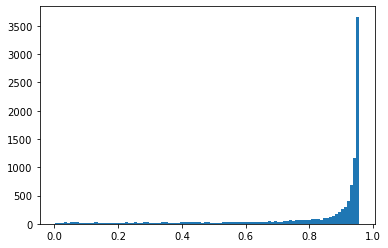

In [66]:


plt.hist(np.array(targets) * 100, bins=100)

In [108]:
n_multiple

107274

In [107]:
n_multiple = 0


for file in tqdm(absoluteFilePaths("../data/rdkit_folder/qm9")):
    with open(file, "rb") as f:
        data = pickle.load(f)
    if data["totalconfs"] != 1:
        n_multiple += 1
    
    '''for conf in data["conformers"]:
        y = conf["totalenergy"]
        #mol = conf["rd_mol"]
        ys.append(y)'''
        

for file in tqdm(absoluteFilePaths("../data/rdkit_folder/drugs")):
    break
    with open(file, "rb") as f:
        data = pickle.load(f)
    if data["totalconfs"] != 1:
        n_multiple += 1
        
    '''for conf in data["conformers"]:
        y = conf["totalenergy"]
        #mol = conf["rd_mol"]
        ys.append(y)'''

119020it [24:30, 80.93it/s] 


KeyError: 'totalconfs'

In [14]:
from rdkit import Chem

suppl = Chem.SDMolSupplier('../data/pcqm4m-v2/pcqm4m-v2-train.sdf')

for mol in suppl:
    print(mol.GetConformer().GetPositions())
    break

[[ 4.9919 -5.2514  4.0126]
 [ 6.1051 -3.0257  3.52  ]
 [ 4.5521 -3.9001  1.914 ]
 [ 6.3372 -1.9217  2.7029]
 [ 4.7751 -2.7953  1.0929]
 [ 2.8586  1.2252 -1.7853]
 [ 2.8118  0.8707 -3.0956]
 [ 5.789  -0.835  -0.8455]
 [ 4.6658 -0.476  -3.0127]
 [ 5.215  -4.0391  3.1392]
 [ 5.677  -1.7955  1.4745]
 [ 4.8499 -0.2104 -1.5946]
 [ 5.9121 -0.5519  0.613 ]
 [ 3.9134  0.7241 -0.934 ]
 [ 5.0405  0.6404  1.1008]
 [ 3.716   0.0207 -3.7371]
 [ 3.9796  1.1019  0.3172]
 [ 5.2985  1.1457  2.1772]]


In [ ]:
from ogb.utils import smiles2graph

from ogb.lsc import PygPCQM4Mv2Dataset
pyg_dataset = PygPCQM4Mv2Dataset(root="../data")

Downloaded 0.06 GB: 100%|██████████| 60/60 [00:03<00:00, 16.06it/s]


Extracting ../data/pcqm4m-v2.zip


Processing...


Converting SMILES strings into graphs...


  2%|▏         | 89934/3746620 [01:17<48:27, 1257.80it/s]  

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123456789)
                for i, (train_idx, val_idx) in enumerate(kfold.split(self.full_data)):
                    if i == self.hparams.fold:
                        break

In [ ]:
from torch_geometric.data import LightningDataset

def get_datamodule(train_data, test_data, fold=0, batch_size=32, num_workers=4):
    if type(fold) != str:
        
    

In [3]:
from torch import nn
import torch_geometric.nn as gnn


class GATNet(nn.Module):
    def __init__(
        self,
        input_dim: int = 15,
        gat_hidden_dim: int = 64,
        edge_dim: int = 3,
        heads: int = 4,
        n_gat_layers: int = 3,
        n_fc_layers: int = 3,
        fc_hidden_dim: int = 256,
        fc_dropout: float = 0.5
    ):
        super().__init__()
        self.gat1 = gnn.GATv2Conv(in_channels=input_dim, 
                                  out_channels=gat_hidden_dim, heads=heads, edge_dim=edge_dim)
        self.gat_list = nn.ModuleList([
            gnn.GATv2Conv(in_channels=gat_hidden_dim*heads, 
                          out_channels=gat_hidden_dim, heads=heads, edge_dim=edge_dim)
            for _ in range(n_gat_layers - 1)
        ])
        self.fc1 = nn.Sequential(
            nn.Linear(gat_hidden_dim * heads, fc_hidden_dim),
            nn.BatchNorm1d(fc_hidden_dim),
            nn.ReLU(),
            nn.Dropout(fc_dropout)
        )
        self.fc_list = nn.ModuleList([
            nn.Sequential(
                nn.Linear(fc_hidden_dim, fc_hidden_dim),
                nn.BatchNorm1d(fc_hidden_dim),
                nn.ReLU(),
                nn.Dropout(fc_dropout)
            ) for _ in range(n_fc_layers - 2)
        ])
        self.do = nn.Dropout(fc_dropout)
        self.fc_last = nn.Linear(fc_hidden_dim, 2)

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.gat1(x, edge_index, edge_attr))
        
        for gat_layer in self.gat_list:
            x = gat_layer(x, edge_index, edge_attr)
            x = F.relu(x)
            
        x = gnn.global_mean_pool(x, batch)
        x = self.fc1(x)
        
        for fc_layer in self.fc_list:
            x = fc_layer(x)
            
        x = self.fc_last(x)
        
        return x

In [18]:
train_data = TrainDataset()
test_data = TestDataset()

dm = BaseDataModule(train_data, test_data, batch_size=32, fold=0)

net = GATNet()
model = BaseNet(net, lr=1e-3, weight_decay=1e-5, max_epochs=30)

trainer = pl.Trainer(max_epochs=30, gpus=[1])

trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type             | Params
---------------------------------------------------
0 | net           | GATNet           | 408 K 
1 | criterion     | MSELoss          | 0     
2 | train_rmse    | MeanSquaredError | 0     
3 | val_rmse      | MeanSquaredError | 0     
4 | val_rmse_best | MinMetric        | 0     
---------------------------------------------------
408 K     Trainable params
0         Non-trainable params
408 K     Total params
1.633     Total estimated model params size (MB)


Epoch 0:  80%|███████▉  | 453/567 [00:15<00:03, 28.99it/s, loss=0.129, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 453/567 [00:15<00:03, 29.75it/s, loss=0.117, v_num=4, val/rmse=0.365, val/rmse_best=0.365]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 453/567 [00:15<00:03, 30.18it/s, loss=0.089, v_num=4, val/rmse=0.354, val/rmse_best=0.354] 
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 453/567 [00:14<00:03, 31.43it/s, loss=0.0826, v_num=4, val/rmse=0.385, val/rmse_best=0.354]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|████▉     | 278/567 [00:10<00:10, 27.58it/s, loss=0.0879, v_num=4, val/rmse=0.292, val/rmse_best=0.292]

In [12]:
num_epochs = 30

model = GATNet(15, 2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs * len(train_dataloader))
device = torch.device("cuda:1")

model.to(device)


for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    train_loss, val_loss = 0., 0.
    
    # train
    model.train()

    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()

        batch = batch.to(device)
        pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = criterion(pred, batch.y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    
    # validation
    model.eval()
    
    for batch in val_dataloader:
        batch = batch.to(device)
        pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = criterion(pred, batch.y)
        val_loss += loss * len(batch.y)
    
    val_loss /= len(val_data)
    
    print(f"Train Loss: {train_loss}")
    print(f"Val Loss: {val_loss}")

Epoch 0


100%|██████████| 453/453 [00:11<00:00, 38.35it/s]


Train Loss: 0.12264837247317463
Val Loss: 0.11823252588510513
Epoch 1


100%|██████████| 453/453 [00:12<00:00, 37.67it/s]


Train Loss: 0.1135789750690755
Val Loss: 0.11279676854610443
Epoch 2


100%|██████████| 453/453 [00:12<00:00, 37.02it/s]


Train Loss: 0.09695399670181158
Val Loss: 0.08205020427703857
Epoch 3


100%|██████████| 453/453 [00:12<00:00, 36.06it/s]


Train Loss: 0.0808124654652925
Val Loss: 0.09489650279283524
Epoch 4


100%|██████████| 453/453 [00:12<00:00, 35.82it/s]


Train Loss: 0.07588006033835558
Val Loss: 0.08151715993881226
Epoch 5


100%|██████████| 453/453 [00:12<00:00, 35.95it/s]


Train Loss: 0.07270524785679171
Val Loss: 0.07278463989496231
Epoch 6


100%|██████████| 453/453 [00:13<00:00, 34.21it/s]


Train Loss: 0.0707416209098256
Val Loss: 0.07197262346744537
Epoch 7


100%|██████████| 453/453 [00:13<00:00, 33.80it/s]


Train Loss: 0.06920491806570662
Val Loss: 0.07027502357959747
Epoch 8


100%|██████████| 453/453 [00:13<00:00, 33.55it/s]


Train Loss: 0.06744053234525074
Val Loss: 0.07098870724439621
Epoch 9


100%|██████████| 453/453 [00:13<00:00, 33.59it/s]


Train Loss: 0.06588058465594224
Val Loss: 0.06632950156927109
Epoch 10


100%|██████████| 453/453 [00:12<00:00, 35.05it/s]


Train Loss: 0.06486200984921019
Val Loss: 0.0678791031241417
Epoch 11


100%|██████████| 453/453 [00:12<00:00, 34.90it/s]


Train Loss: 0.06371644361327027
Val Loss: 0.06562931090593338
Epoch 12


100%|██████████| 453/453 [00:13<00:00, 34.47it/s]


Train Loss: 0.06215264864068552
Val Loss: 0.06718893349170685
Epoch 13


100%|██████████| 453/453 [00:13<00:00, 34.36it/s]


Train Loss: 0.06086020463580064
Val Loss: 0.061521340161561966
Epoch 14


100%|██████████| 453/453 [00:11<00:00, 38.91it/s]


Train Loss: 0.059979709070874895
Val Loss: 0.06226282939314842
Epoch 15


100%|██████████| 453/453 [00:11<00:00, 38.48it/s]


Train Loss: 0.059344057733846815
Val Loss: 0.0634029284119606
Epoch 16


100%|██████████| 453/453 [00:12<00:00, 34.91it/s]


Train Loss: 0.05834461612499445
Val Loss: 0.060086771845817566
Epoch 17


100%|██████████| 453/453 [00:12<00:00, 36.73it/s]


Train Loss: 0.05679242212169086
Val Loss: 0.05918416753411293
Epoch 18


100%|██████████| 453/453 [00:12<00:00, 37.61it/s]


Train Loss: 0.05571853669635771
Val Loss: 0.058793921023607254
Epoch 19


100%|██████████| 453/453 [00:11<00:00, 37.77it/s]


Train Loss: 0.054527673138424784
Val Loss: 0.05806384235620499
Epoch 20


100%|██████████| 453/453 [00:11<00:00, 37.97it/s]


Train Loss: 0.05377750939979459
Val Loss: 0.058353133499622345
Epoch 21


100%|██████████| 453/453 [00:12<00:00, 36.44it/s]


Train Loss: 0.05272164444539852
Val Loss: 0.05835919827222824
Epoch 22


100%|██████████| 453/453 [00:12<00:00, 35.13it/s]


Train Loss: 0.05194892519242058
Val Loss: 0.057384613901376724
Epoch 23


100%|██████████| 453/453 [00:12<00:00, 35.65it/s]


Train Loss: 0.05119385129091624
Val Loss: 0.05701125040650368
Epoch 24


100%|██████████| 453/453 [00:12<00:00, 35.18it/s]


Train Loss: 0.05046723569202634
Val Loss: 0.05732369422912598
Epoch 25


100%|██████████| 453/453 [00:12<00:00, 36.71it/s]


Train Loss: 0.0499665065777486
Val Loss: 0.05713200941681862
Epoch 26


100%|██████████| 453/453 [00:12<00:00, 35.90it/s]


Train Loss: 0.04949362321487457
Val Loss: 0.0570257306098938
Epoch 27


100%|██████████| 453/453 [00:12<00:00, 36.69it/s]


Train Loss: 0.04914069553183404
Val Loss: 0.056887321174144745
Epoch 28


100%|██████████| 453/453 [00:12<00:00, 37.17it/s]


Train Loss: 0.04893808028605205
Val Loss: 0.05693376436829567
Epoch 29


100%|██████████| 453/453 [00:12<00:00, 36.22it/s]


Train Loss: 0.04880983686736614
Val Loss: 0.056932494044303894


In [ ]:
preds = []

model.eval()
for batch in tqdm(test_dataloader):
    batch = batch.to(device)
    pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
    preds.append(pred)

preds = torch.cat(preds).detach().cpu().numpy()

sub_df = pd.read_csv("data/sample_submission.csv")
sub_df["Reorg_g"] = preds[:, 0]
sub_df["Reorg_ex"] = preds[:, 1]
sub_df.to_csv("submission.csv", sep=",", index=False)